<h1><center><br> Text Classification with Naive Bayes </center></h1>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

The dataset that we will work with is a selection of posts from scikit-learn's ['20 newsgroups' dataset](https://scikit-learn.org/stable/datasets/real_world.html#newsgroups-dataset). We will be working with just two of the 20 newsgroup categories:  'comp.graphics' (computer graphics) and 'rec.motorcycles' (recreation motorcycles). 

The cell below loads the data from a pickle file. The varaibles are:

+ `Xtrain`: A list of documents used for training
+ `ytrain`: The category of each training document
+ `Xtest`: A list of documents used for testing
+ `ytest`: The category of each testing document
+ `categories`: The set of all categories
+ `vocabulary`: The feature set, ie words used in the model

In [3]:
with open('Text_Classification.pickle','rb') as file:
    Xtrain, ytrain, Xtest, ytest, categories, vocabulary = pickle.load(file)
    
N = Xtrain.shape[0]   # number of documents in the training corpus
K = len(categories)   # number of document categories (classes)
D = len(vocabulary)   # number of words in the vocabulary (features)

# 1. Find the number of training documents for each category

In [4]:
docs_per_category = dict.fromkeys(categories, 0)

docs_per_category['comp.graphics'] = np.count_nonzero(ytrain == 'comp.graphics')
docs_per_category['rec.motorcycles'] = np.count_nonzero(ytrain == 'rec.motorcycles')

# 2. Create a bag-of-words representation for each document

Our Naive Bayes algorithm will operate on a bag-of-words representation of each document. The first step is to write the `to_bow` method. 

The argument for this method is `doc`, which is an element of `X` (ie a string). It should return a `set` with the unique words that appear in both the document and the vocabulary. 

In [5]:
def to_bow(doc):
    bow = set()
    
    # Split `doc` at spaces using the the string's `split` method. Obtain a list.                             
    bow_list = doc.split()
    
    # Keep only unique words from the list, by casting it as a set. 
    bow_set = set(bow_list)
    
    # From that set, keep only the ones that are present in the vocabulary.
    bow = bow_set.intersection(vocabulary)
    
    return bow

In [6]:
Xtrain_bow = np.array([to_bow(doc) for doc in Xtrain])

# 3. Compute the document count for each word in each category

To estimate probabilities for Naive Bayes, we will need to know, for each category and each word, the number of documents of the category that contain the word. We will implement the `find_doc_counts_per_word_category` function.

In [7]:
def find_doc_counts_per_word_category(categories,vocabulary,ytrain,Xtrain_bow):

    # Initialize the dictionary
    doc_counters = dict.fromkeys(categories) 
    for category in categories:
        doc_counters[category]  = dict.fromkeys(vocabulary,0)

    # Loop through categories and documents in that category. 
    # For each word in the vocabulary that is also in the document, increment the corresponding counter by 1. 
    for category in categories:
        
        
        # Filter Xtrain_bow and keep only the documents of this category
        docs_in_category = Xtrain_bow[ytrain == category]

        # For each document in the category, increment the appropriate counters
        for doc in docs_in_category:
            intsct = doc.intersection(vocabulary)
            if len(intsct) != 0:
                for word in intsct:
                    doc_counters[category][word] += 1
                    
    return doc_counters

In [8]:
doccount_per_cat_and_word = find_doc_counts_per_word_category(categories,vocabulary,ytrain,Xtrain_bow)

# 4. Find word frequencies per category

We will write the `compute_word_freq` function. 

The argument for this method is the Laplace smoothing factor `alpha`. It also uses global variables, including `doccount_per_cat_and_word`.

For each category and word, we will compute the Laplace-smoothed ratio of the number of documents containing the word, to the total number of documents in the category. 

Steps:

1. For each category and word in the vocabulary, compute $\rho_{d,k}$  as

$$\rho_{d,k} = \frac{(\text{# documents of category $k$ that contain word $d$}) + \alpha}{(\text{# documents of category $k$})+\alpha K}$$

Store it in `wordfreq[category][word]`.

2. For each category, compute $\rho_k$  as
    
$$\rho_k = \frac{\text{# documents of category $k$}}{\text{Total # documents}}$$

Store it in `catfreq[category]`.

In [9]:
def compute_word_freq(alpha):

    D = len(vocabulary)

    # Initialize `wordlogfreq` and `wordlogfreq`
    wordfreq = dict.fromkeys(categories)
    for category in categories:
        wordfreq[category] = dict.fromkeys(vocabulary, 0)
    ndocs = dict.fromkeys(categories)
    catfreq = dict.fromkeys(categories)
    
    # Steps 1 and, compute wordlogfreq and doclogfreq
    for category in categories:
        ndocs[category] = docs_per_category[category]
        
        for word in vocabulary:
            wordfreq[category][word] += (doccount_per_cat_and_word[category][word] + alpha) / (ndocs[category] + alpha * K)
    
        catfreq[category] = ndocs[category] / N
    
    return wordfreq, catfreq

In [10]:
wordfreq, catfreq = compute_word_freq(0.01)

# 5. Write the Naive Bayes prediction function.

Now we are computing the Naive Bayes prediction of the category for the given test document `xtest`. 

The arguments for this method are 
+ xtest: a single test document as a string.
+ wordfreq, catfreq: the ratios computed in the previous step (with $\alpha=0.1$)

The steps for are:
1. Find the BOW representation of `xtest`.

2. Use the dictionary `score_cat` to store the score for each of the categories.

3. Loop through categories, for each one compute its score with

$$\log\rho_k+ \sum_{d:\:x_d=1} \log\rho_{d,k} + \sum_{d:\:x_d=0} \log(1-\rho_{d,k})$$

Here $x_d$ is the $d$'th word in `xtest`

4. Return the category with the highest score. 

In [11]:
def predict(Xtest, wordfreq, catfreq):

    # 1. Find the BOW representation of Xtest.
#     Xtest_bow = np.array([to_bow(doc) for doc in Xtest])
#     for i in range(len(Xtest_bow) - 1):
#         a = Xtest_bow[i].union(Xtest_bow[i + 1])
    Xtest_bow = to_bow(Xtest)

    # 2. Use a dictionary to store the score for each of the categories.
    score_cat = dict.fromkeys(categories,0)

    # 3. Loop through categories, for each one compute its score, and save it in score_cat.
    for category in categories:
        score_cat[category] += np.log(catfreq[category])
        for word in vocabulary:
            if word in Xtest_bow:
                score_cat[category] += np.log(wordfreq[category][word])
            else:
                score_cat[category] += np.log(1 - wordfreq[category][word])

    # 4. Return the category with the highest score.
    return max(score_cat, key=score_cat.get)

# 6. Compute accuracy

Accuracy is defined as the number of correct predictions, divided by the total number of predictions. 

In [12]:
def compute_accuracy(Xin, yin, wordfreq, catfreq):

    correct = 0
    
    # count the number of correct predictions
    for i in range(len(Xin)):
        if predict(Xin[i], wordfreq, catfreq) == yin[i]:
            correct += 1
        
    return correct / len(Xin)

# 7. Compute the training and testing errors for a range of $\alpha$

### 7.1. Train the model and compute its test accuracy for logarithmically spaced values of $\alpha$ ranging from $10^{-5}$ to $10^1$

Here 'training the model' means computing the Laplace-smoothed document frequencies with `compute_word_freq`. We will do this for a range of $\alpha$'s and store their corresponding accuracies. 

In [14]:
alphas = np.logspace(-5,1,20)
acc = np.empty(len(alphas))
for i in range(len(alphas)):
    wordfreq, catfreq = compute_word_freq(alphas[i])
    
    acc[i] = compute_accuracy(Xtest, ytest, wordfreq, catfreq)

### 7.2. Plot the accuracies as a function of $\alpha$ using `plt.semilogx`

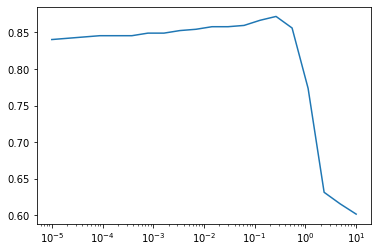

In [15]:
plt.figure()

plt.semilogx(alphas, acc)

plt.show()

### 7.3. Find the optimal $\alpha$ and its corresponding accuracy

In [16]:
best_acc = acc[np.argmax(acc)]
best_alpha = alphas[np.argmax(acc)]